## Duration analysis

In [1]:
from config import DRIVE_PATH_VIVA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os

### Load data

In [2]:
label_path_bert = os.path.join(DRIVE_PATH_VIVA, 'Education_videos_7_classified_BERT_batch_0_10000.csv')
label_path_bart = os.path.join(DRIVE_PATH_VIVA, 'Education_videos_7_classified_BART_batch_0_10000.csv')


In [3]:
figures_path = os.path.join('data','figures', 'duration_analysis')    
os.makedirs(figures_path, exist_ok=True)

In [4]:
general_path = os.path.join(DRIVE_PATH_VIVA, 'extracted_Education')
dir_list = os.listdir(general_path)
total_df = pd.DataFrame()
for dir in dir_list:
    batch_dir = os.path.join(general_path, dir)
    batch_df = pd.read_csv(batch_dir)
    total_df = pd.concat([total_df, batch_df])

In [5]:
channels_df = pd.read_csv('data/raw/df_channels_en.tsv', sep = "\t")
channels_df["join_date"] = pd.to_datetime(channels_df["join_date"])
print(channels_df.shape)

(136470, 8)


In [6]:
total_df.head(2)

,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,0,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,A video to teach the kids to Learn the Colors ...,3.0,jCaqrZ8gSkY,116,11.0,"learn colors,kids colors,colors kids,count to ...",Learn Colors and Count to Ten with Colors Disn...,2016-05-03 00:00:00,2720.0
1,1,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.397758,Subscribe for more: https://goo.gl/JI78Ak\nNew...,1094.0,VZ6_wQxKVSI,940,2884.0,"lego city,lego police,lego,playmobil,lego robb...",Lego city police fireman bank robber boat race...,2015-06-30 00:00:00,4530589.0


In [7]:
total_df['duration_in_min'] = total_df['duration']/60

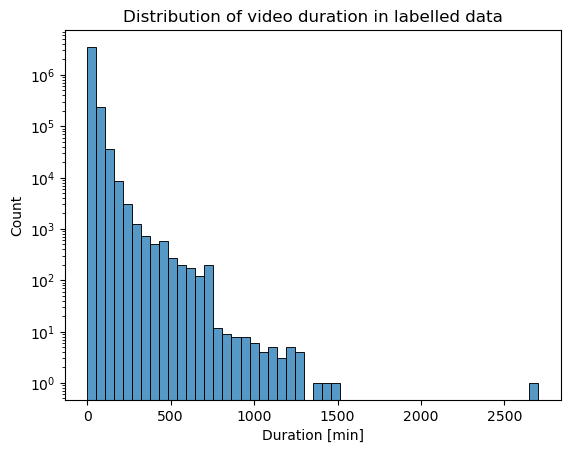

In [8]:
sns.histplot(data = total_df, x = 'duration_in_min', bins = 50)
plt.title('Distribution of video duration in labelled data')
plt.xlabel('Duration [min]')
plt.yscale('log')
#plt.xlim(0,500)

### Analysis

> power law
>
> A lot of short videos. but is that correlated with good videos?
> 
> what are the big videos???
>
> plot distrib based on channel category (expecting nature videos to be longer)


In [9]:
total_df = total_df.dropna()

In [10]:
print(len(total_df))

3146170


> Adding the channel col

In [21]:
# Create a dictionary mapping channel to category_cc from df2
category_map = channels_df.set_index('channel')['category_cc'].to_dict()

# Map the category_cc to df1 based on channel id
total_df['channel_category'] = total_df['channel_id'].map(category_map)


In [22]:
total_df.head(2)

,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,duration_in_min,upload_year,channel_category
0,0,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,A video to teach the kids to Learn the Colors ...,3.0,jCaqrZ8gSkY,116,11.0,"learn colors,kids colors,colors kids,count to ...",Learn Colors and Count to Ten with Colors Disn...,2016-05-03 00:00:00,2720.0,1.933333,2016,Gaming
1,1,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:30.397758,Subscribe for more: https://goo.gl/JI78Ak\nNew...,1094.0,VZ6_wQxKVSI,940,2884.0,"lego city,lego police,lego,playmobil,lego robb...",Lego city police fireman bank robber boat race...,2015-06-30 00:00:00,4530589.0,15.666667,2015,Gaming


In [23]:
median = total_df['duration_in_min'].median()
print('Median: {:.3f} minutes'.format(median))

Median: 7.083 minutes


## > Refaire pour 2016-2019

In [24]:
total_df['upload_date'].iloc[0] #--> year is the first 4 characters

total_df['upload_year'] = total_df['upload_date'].apply(lambda x : int(x[0:4]))


In [25]:
# select the years
period = [2015, 2016, 2017, 2018, 2019]

period_data = total_df[total_df['upload_year'].isin(period)]
print(len(period_data))

2363900


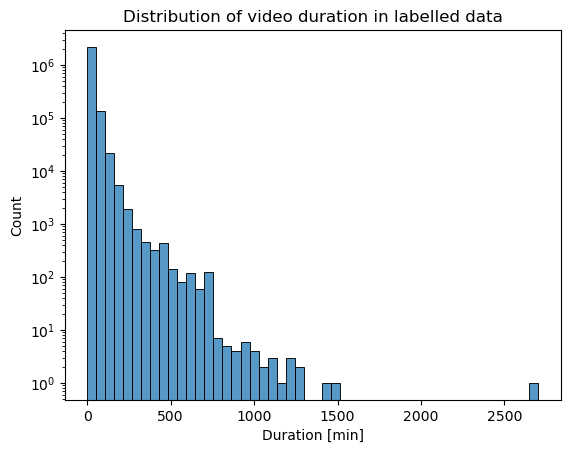

In [15]:
# Plot new distribution
sns.histplot(data = period_data, x = 'duration_in_min', bins = 50)
plt.title('Distribution of video duration in labelled data')
plt.xlabel('Duration [min]')
plt.yscale('log')
#plt.xlim(0,500)

> Plot distribution based on label of interest (purpose vs content/ channel category in the meantime)

In [26]:
# Remove 'nan' channel category

period_data = period_data[period_data['channel_category'] != 'nan']

In [ ]:
print(period_data['channel_category'].value_counts())
#print(medians)


channel_category
Education                2037369
Entertainment              83727
People & Blogs             60563
Howto & Style              39240
Science & Technology       37502
News & Politics            33537
Music                      14012
Film and Animation         13293
Gaming                     11729
Nonprofits & Activism      11150
Travel & Events             7168
Sports                      5770
Autos & Vehicles            4343
Comedy                      2141
Pets & Animals              1858
Name: count, dtype: int64


In [ ]:
label_chosen = 'channel_category'

label_stats = period_data.groupby(label_chosen)['duration_in_min'].describe() # get the subjects with long context
medians = label_stats.sort_values(by='50%', ascending=False)['50%'] 

period_data[label_chosen] = period_data[label_chosen].astype(str)
medians.index = medians.index.astype(str)

fig, axs = plt.subplots(figsize=(12,8))
sns.boxplot(data=period_data, x=label_chosen, y='duration_in_min', hue =label_chosen, ax=axs, order = medians.index) # ordered by median 
plt.title(f'Boxplot Distributions of Video Duration for {label_chosen} between {period[0]} and {period[-1]}')
plt.xticks(rotation=45)
plt.xlabel(label_chosen)
plt.yticks(np.arange(0, 1000, 100))
plt.ylabel('Duration [log(min)]')
plt.yscale('log')
axs.xaxis.grid(False)
axs.yaxis.grid(True)
plt.tight_layout()


plt.savefig(os.path.join(figures_path, f'boxplot_duration_{label_chosen}'))

In [ ]:
top_period_duration = period_data.nlargest(10, ['duration_in_min'])


## Huge distrib plots for likes/dislikes/views

In [27]:
# Add duration bin columns
duration_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 90, 120, float('inf')]
duration_bin_titles = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-40', 
                       '40-50', '50-60', '60-90', '90-120', '>120']

# Create duration_bin column
period_data['duration_bin'] = pd.cut(period_data['duration_in_min'], bins=duration_bins, labels=duration_bin_titles, right=False)


In [28]:
period_data.head(1)

,Unnamed: 0,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,duration_in_min,upload_year,channel_category,duration_bin
0,0,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,A video to teach the kids to Learn the Colors ...,3.0,jCaqrZ8gSkY,116,11.0,"learn colors,kids colors,colors kids,count to ...",Learn Colors and Count to Ten with Colors Disn...,2016-05-03 00:00:00,2720.0,1.933333,2016,Gaming,0-5


Text(78.72222222222221, 0.5, 'Video Count (x10^5)')

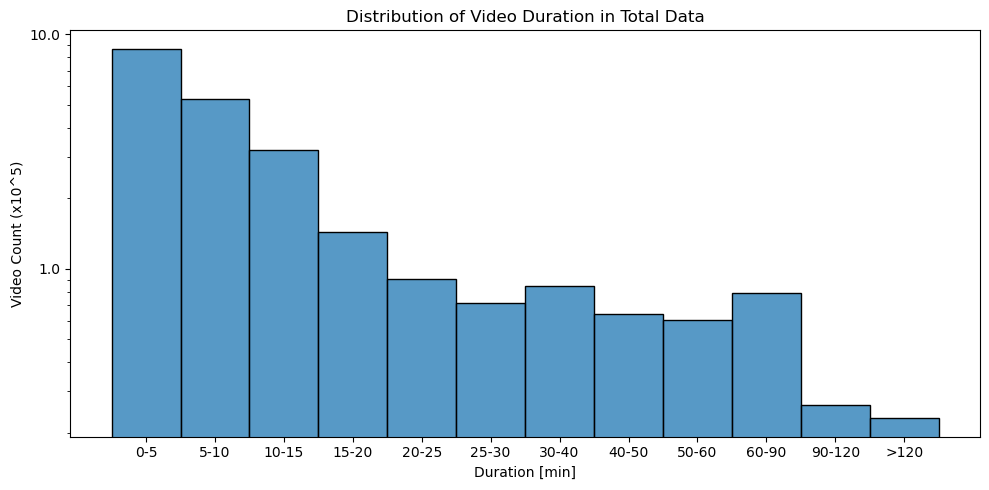

In [ ]:
# Plot new distribution

fig = plt.figure(figsize = (10, 5))
sns.histplot(data = period_data, x = 'duration_bin')
plt.title('Distribution of Video Duration in Total Data')
plt.xlabel('Duration [min]')

# Set log scale for the y-axis
plt.yscale('log')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e5:.1f}'))

# Show grid and tight layout
plt.tight_layout()
plt.ylabel('Video Count (x10^5)')

Text(65.34722222222221, 0.5, 'Video Count (x10^5)')

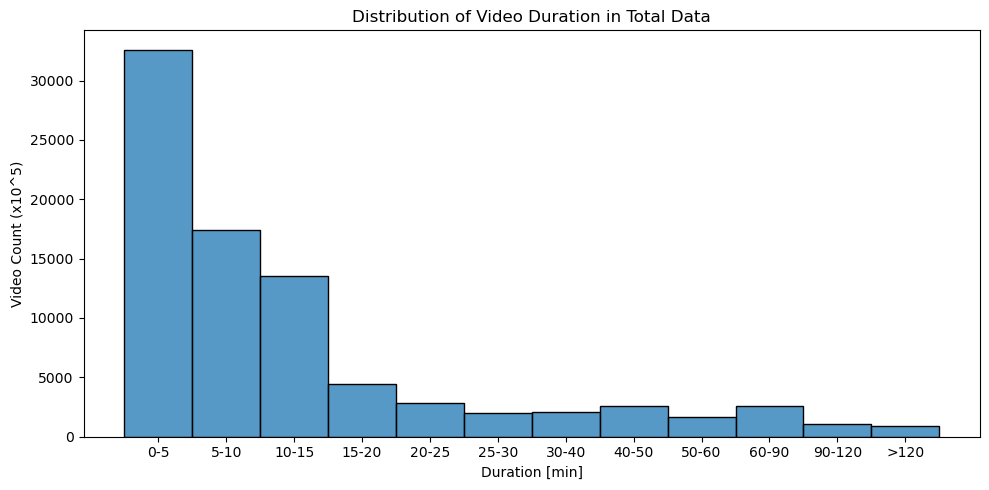

In [ ]:
# Plot new distribution

fig = plt.figure(figsize = (10, 5))
sns.histplot(data = period_data[period_data['channel_category'] == 'Entertainment'], x = 'duration_bin')
plt.title('Distribution of Video Duration in Total Data')
plt.xlabel('Duration [min]')

# Set log scale for the y-axis
# plt.yscale('log')

# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e5:.1f}'))

# Show grid and tight layout
plt.tight_layout()
plt.ylabel('Video Count (x10^5)')

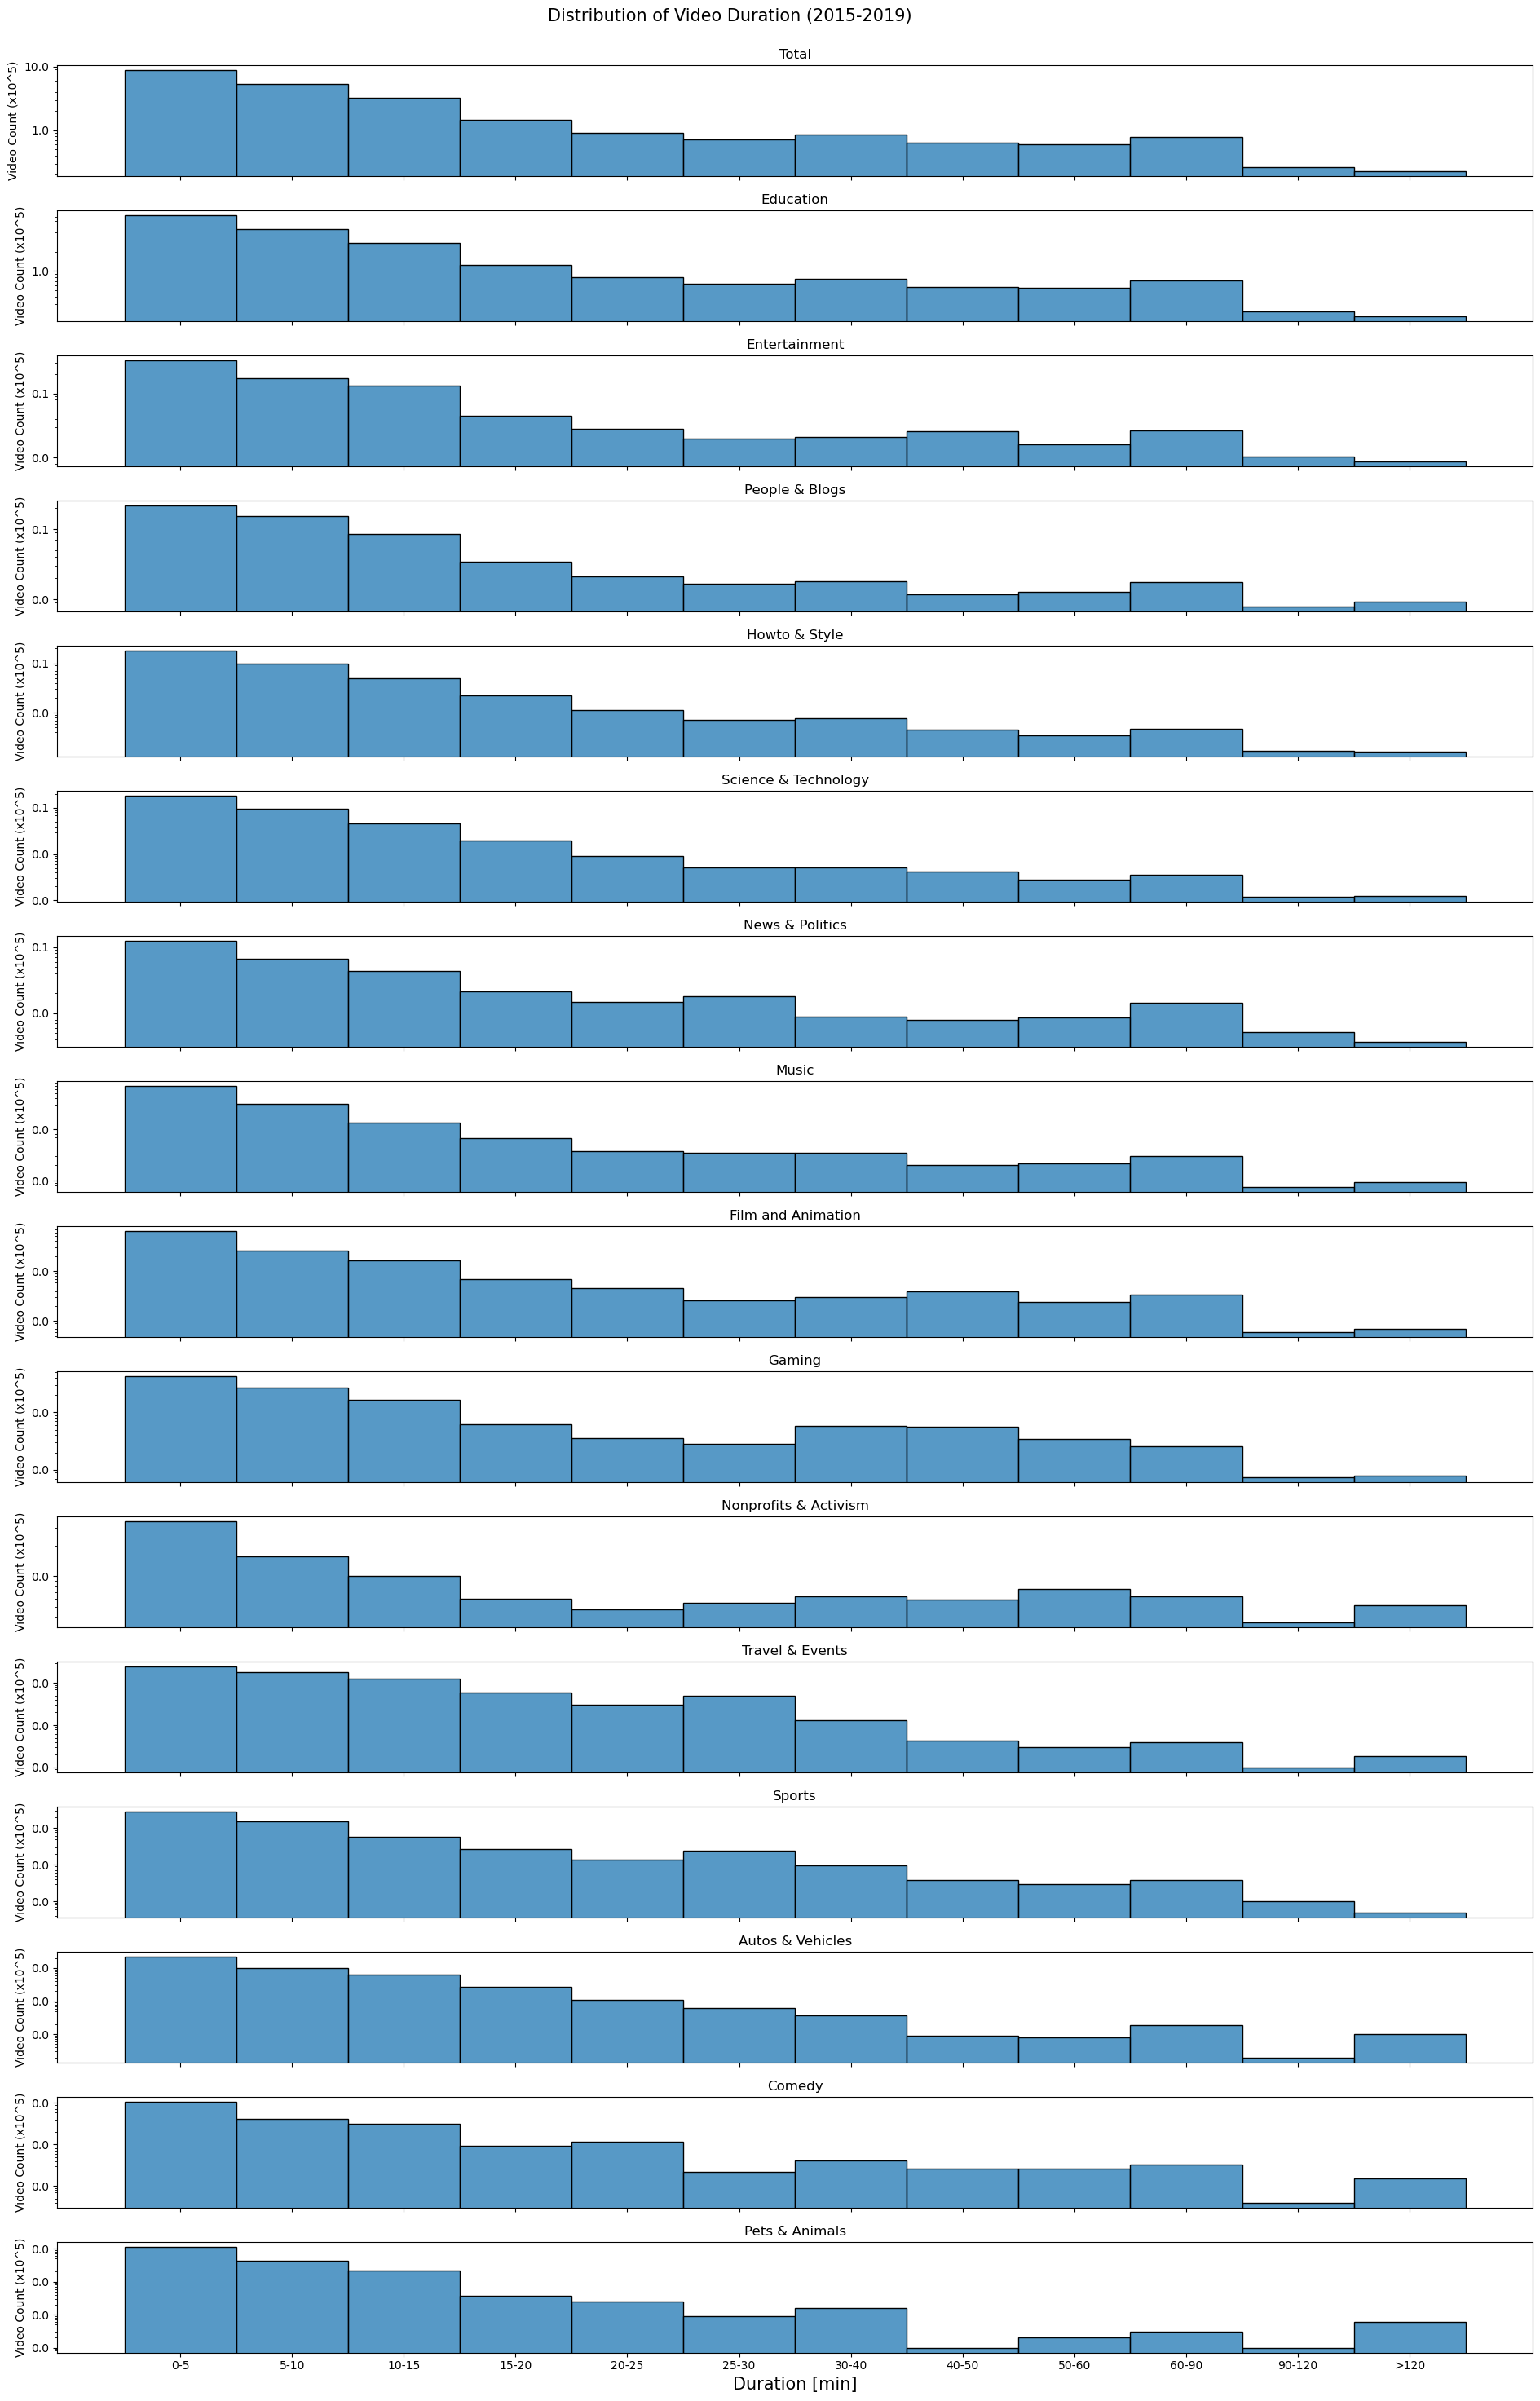

In [ ]:
label_chosen = 'channel_category'

total_labels = list(period_data[label_chosen].value_counts().index)
n_plots = len(total_labels)

fig, axs = plt.subplots(n_plots+1, 1, figsize = (20, 30), sharex = True)
for i, ax in enumerate(fig.axes):    
    
    if i == 0:
        sns.histplot(data = period_data, x = 'duration_bin', ax = ax)
        ax.set_title('Total')
    else:
        sns.histplot(data = period_data[period_data[label_chosen] == total_labels[i-1]], x = 'duration_bin', ax = ax)
        ax.set_title(total_labels[i-1])
        
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e5:.1f}'))
    ax.set_ylabel('Video Count (x10^5)') 


plt.xlabel('Duration [min]', fontsize = 15)
plt.suptitle(f'Distribution of Video Duration ({period[0]}-{period[-1]})', fontsize = 15)
plt.tight_layout(rect=[0.05, 0, 1, 0.98])
plt.savefig(os.path.join(figures_path, f'histograms_duration_{label_chosen}'))


In [ ]:
print(period_data['duration_bin'].value_counts())

duration_bin
0-5       867122
5-10      532129
10-15     321170
15-20     144030
20-25      90112
30-40      84849
60-90      78808
25-30      71590
40-50      63999
50-60      60247
90-120     26279
>120       23067
Name: count, dtype: int64


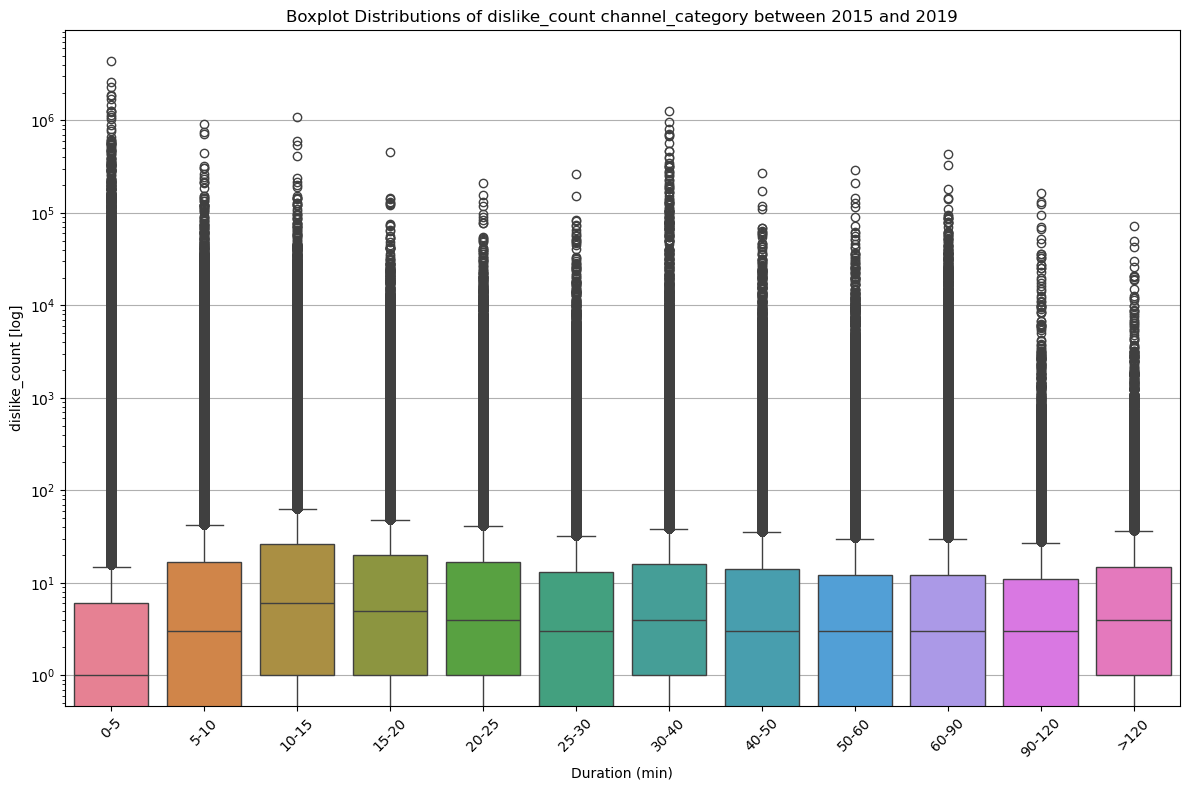

In [ ]:
# for all 
label_chosen = 'channel_category'
metric = 'dislike_count' # like_count, dislike_count, view_count


fig, axs = plt.subplots(figsize=(12,8))
sns.boxplot(data=period_data, x='duration_bin', y=metric, hue = 'duration_bin', ax=axs) # ordered by median 
plt.title(f'Boxplot Distributions of {metric} {label_chosen} between {period[0]} and {period[-1]}')
plt.xticks(rotation=45)
plt.xlabel('Duration (min)')
plt.ylabel(f'{metric} [log]')
plt.yscale('log')
axs.xaxis.grid(False)
axs.yaxis.grid(True)
plt.tight_layout()


plt.savefig(os.path.join(figures_path, f'boxplot_{metric}_all'))

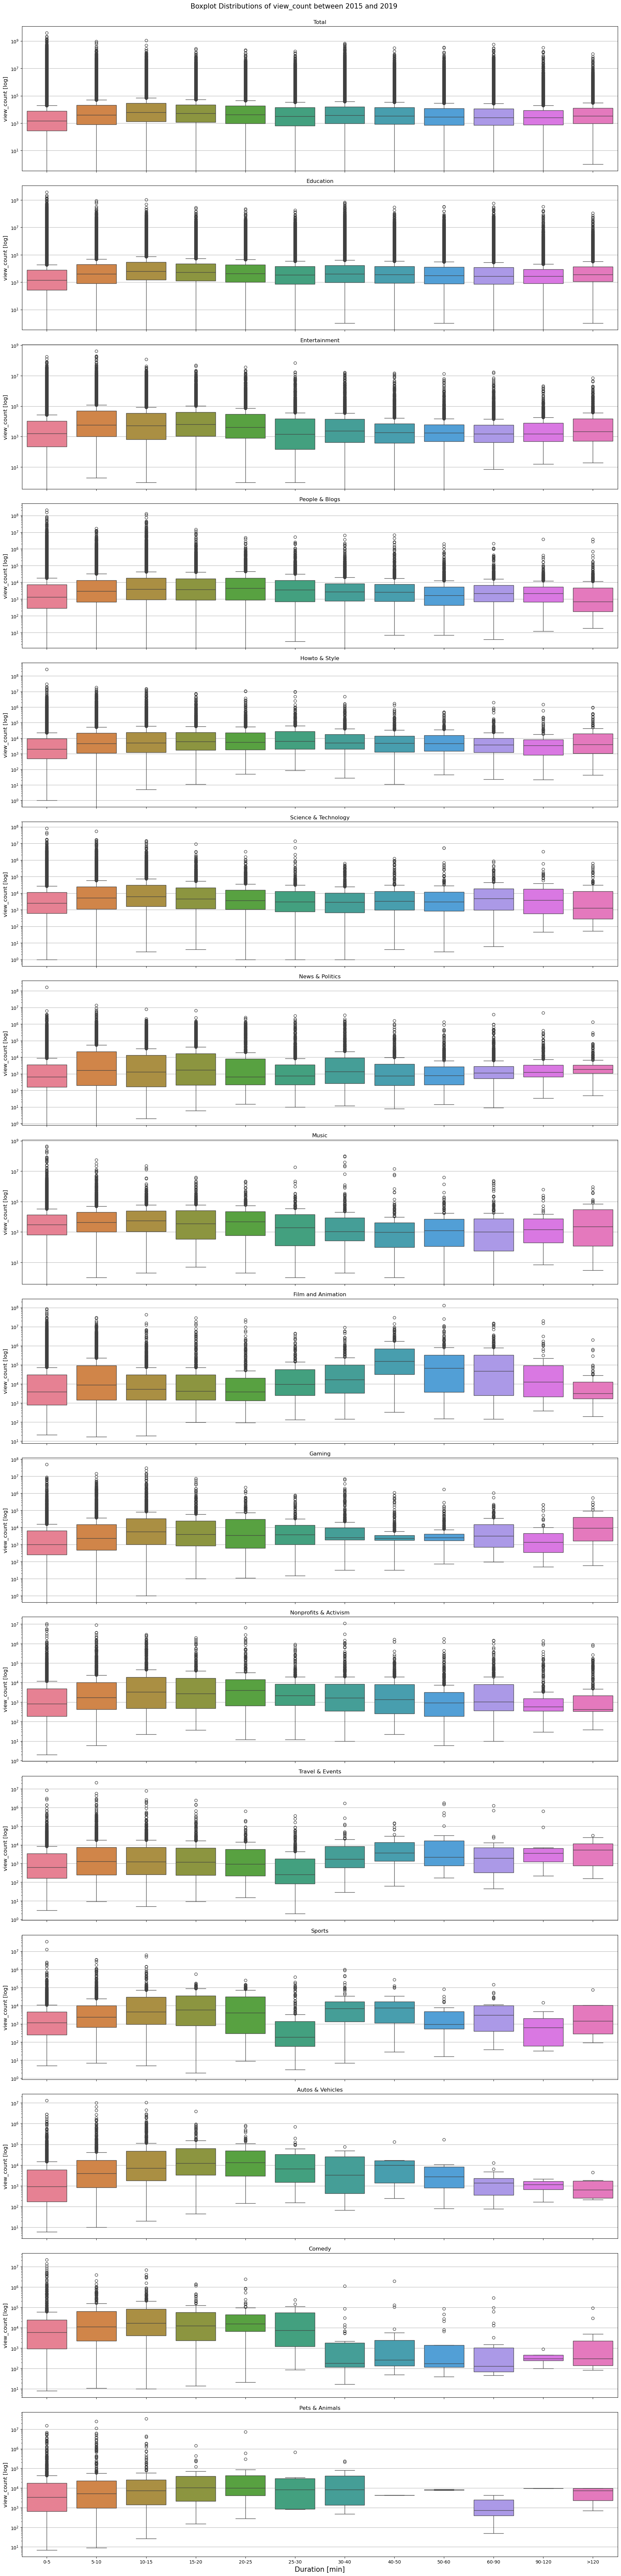

In [ ]:
label_chosen = 'channel_category'
metric = 'view_count' # like_count, dislike_count, view_count

total_labels = list(period_data[label_chosen].value_counts().index)
n_plots = len(total_labels)

fig, axs = plt.subplots(n_plots + 1, 1, figsize=(20, 80), sharex=True)

for i, ax in enumerate(axs):
    if i == 0:
        sns.boxplot(data=period_data, x='duration_bin', y=metric, hue='duration_bin', ax=ax)
        ax.set_title('Total')
    else:
        sns.boxplot(data=period_data[period_data[label_chosen] == total_labels[i - 1]], 
                    x='duration_bin', y=metric, hue='duration_bin', ax=ax)
        ax.set_title(total_labels[i - 1])

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_yscale('log')
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e5:.1f}'))
    ax.set_ylabel(f'{metric} [log]', fontsize=12)

plt.xlabel('Duration [min]', fontsize=15)
plt.suptitle(f'Boxplot Distributions of {metric} between {period[0]} and {period[-1]}', fontsize=15)
plt.tight_layout(rect=[0.05, 0, 1, 0.98])  # adjust the layout to avoid overlapping
plt.savefig(os.path.join(figures_path, f'boxplot_{metric}_{label_chosen}'))


In [92]:
# do on 2018 year
year = 2018
year_data = period_data.loc[(period_data['upload_year']== year) & (period_data['view_count']>0)]


def get_metric_per_view(row, metric):
    return row[metric]/row['view_count']

year_data['likes_per_view']= year_data.apply(lambda x: get_metric_per_view(x, 'like_count'), axis = 1)
year_data['dislikes_per_view']= year_data.apply(lambda x: get_metric_per_view(x, 'dislike_count'), axis = 1)

/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/1628558293.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['likes_per_view']= year_data.apply(lambda x: get_metric_per_view(x, 'like_count'), axis = 1)
/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/1628558293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_data['dislikes_per_view']= year_data.apply(lambda x: get_metric_per_view(x, 'dislike_count'), axis = 1)


In [117]:
#print(bin_counts)
print(likes_per_view.values*100)
# print(dislikes_per_view)
# print(avg_views_per_video)

[2.32347122 3.2830019  2.8767596  3.31560486 2.48237948 3.48157752
 2.38127027 2.62824092 2.87274364 6.14934065        nan 2.89319884]


In [129]:
year_data = year_data.dropna(subset=['channel_category'])

/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/2952628522.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = cat_data.groupby('duration_bin')['duration_bin'].count()
/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/2952628522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  likes_per_view = cat_data.groupby('duration_bin')['likes_per_view'].mean()
/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/2952628522.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

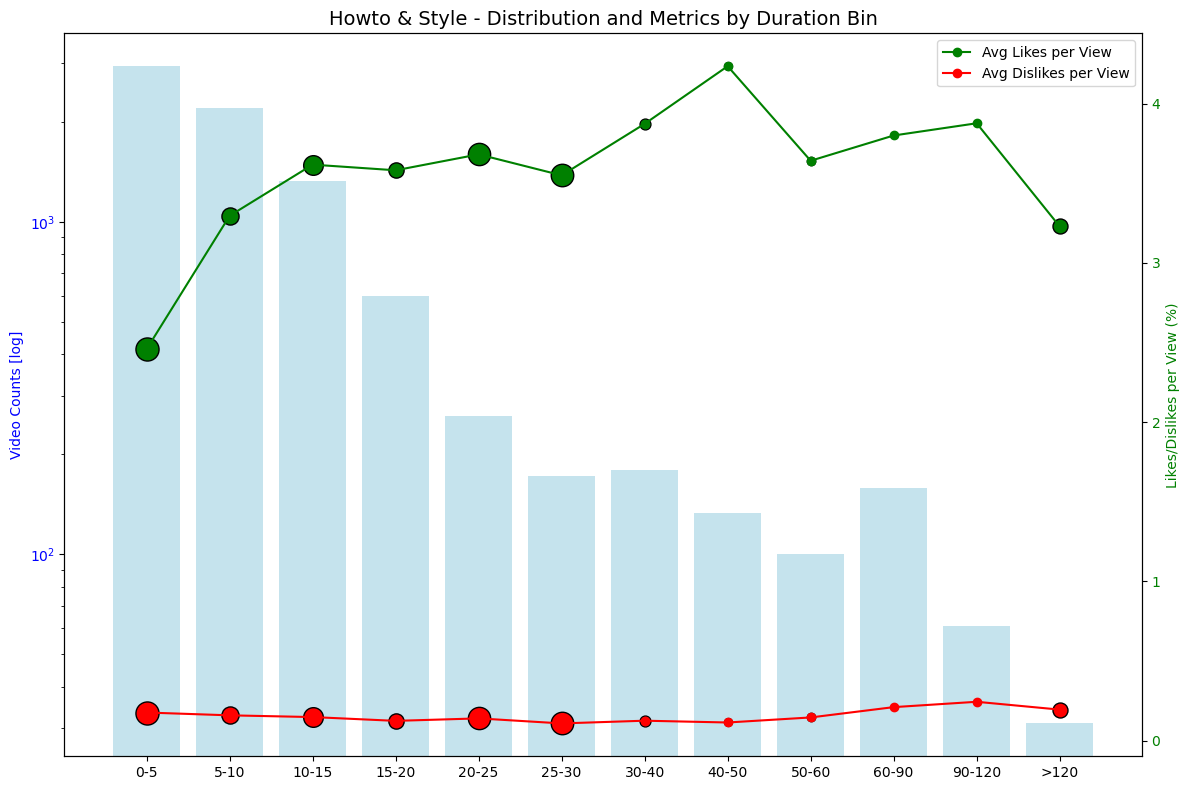

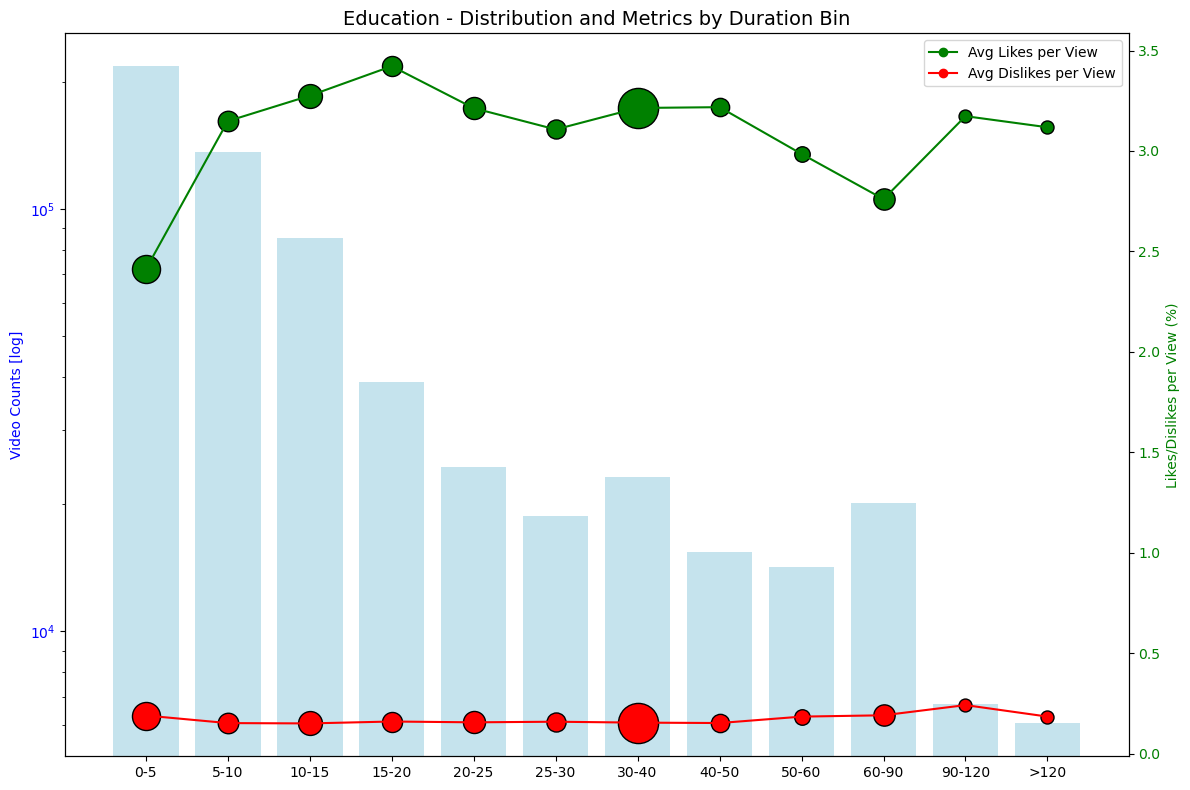

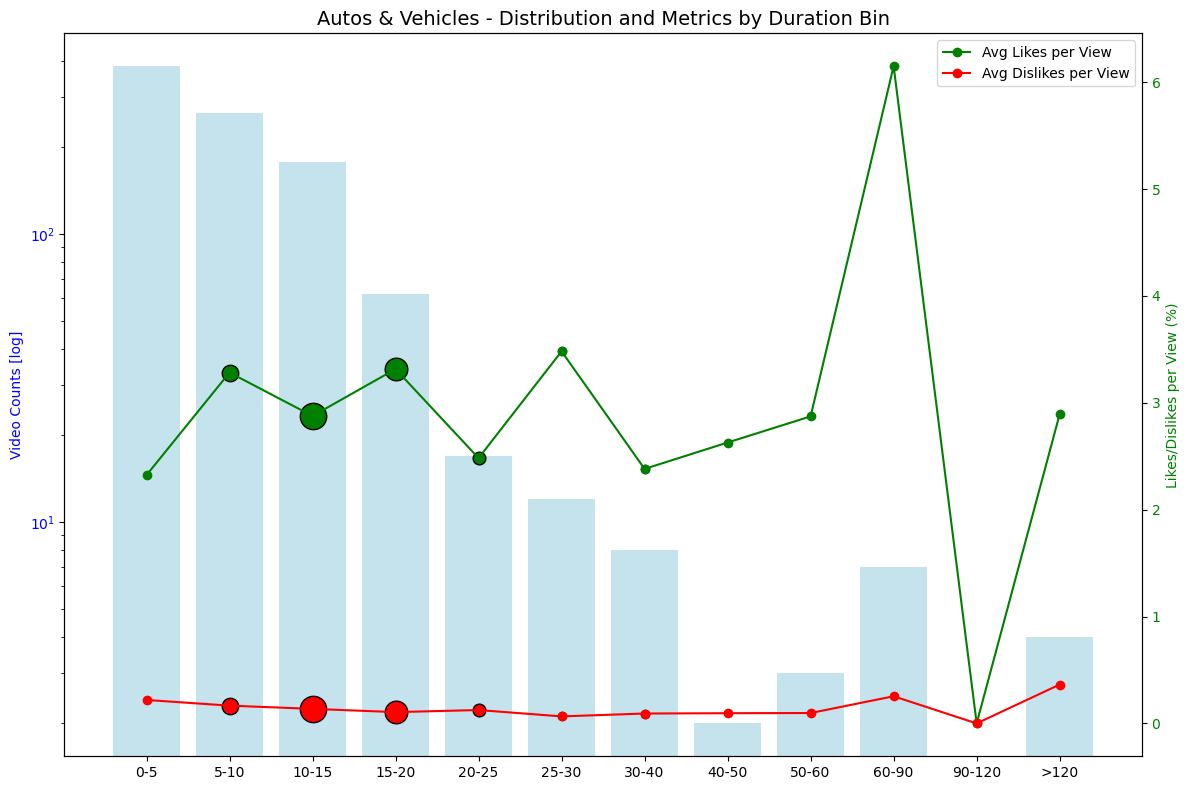

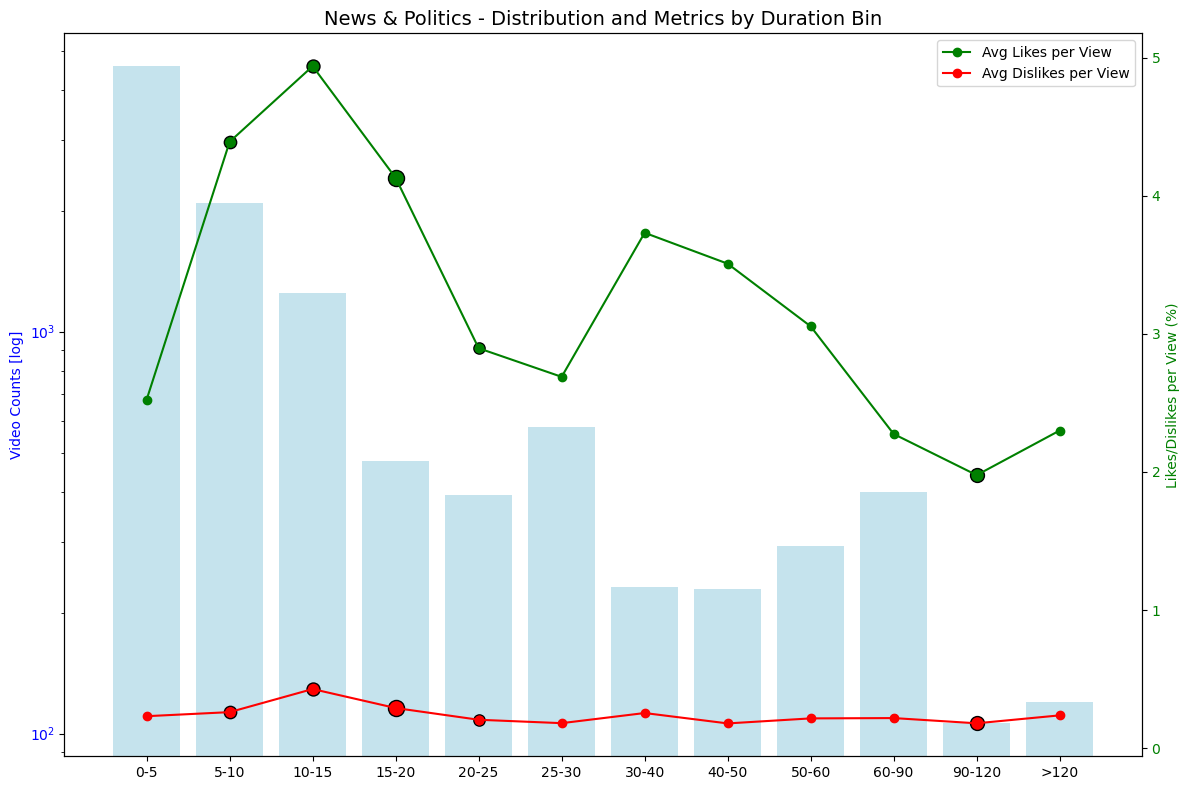

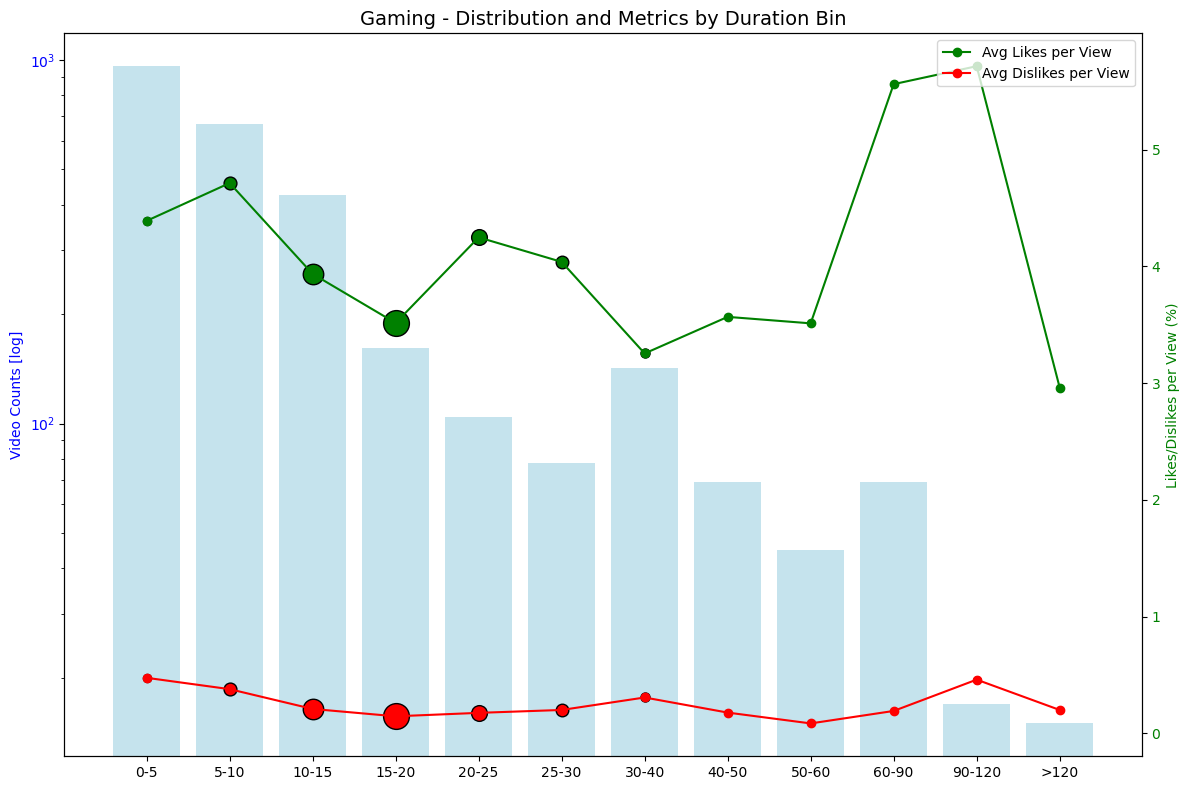

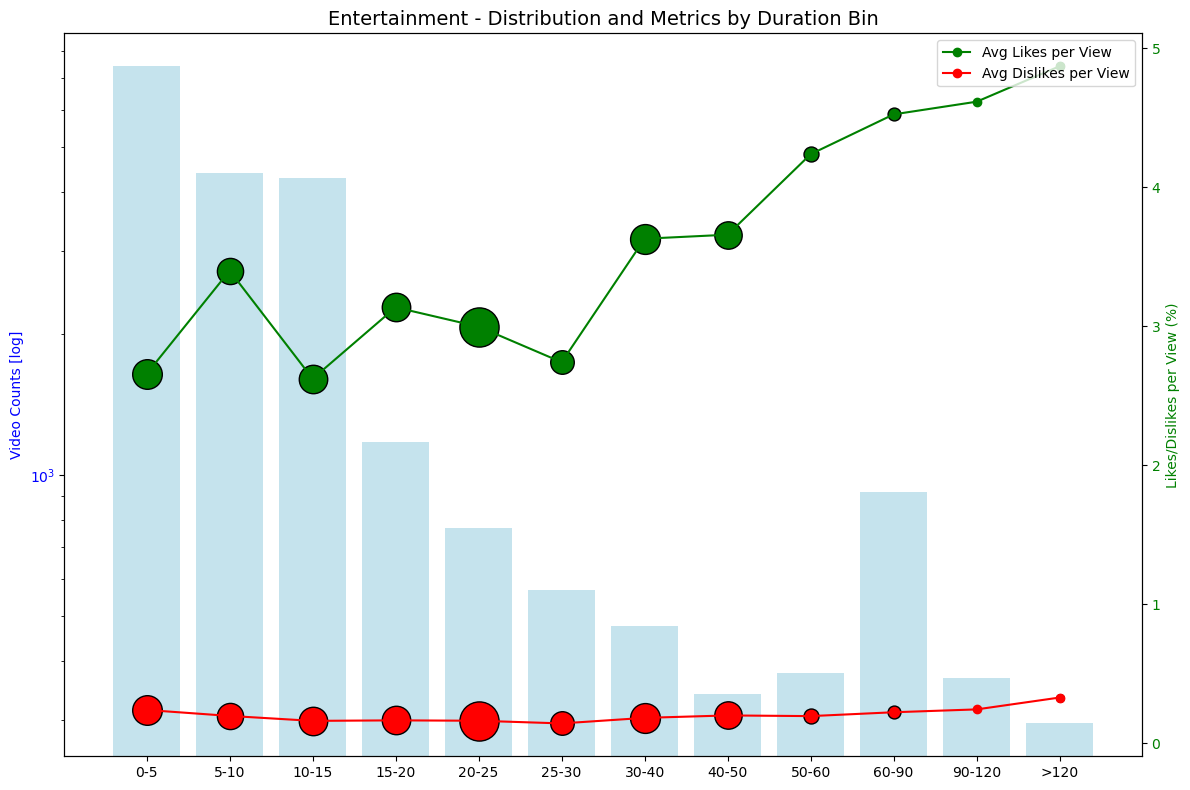

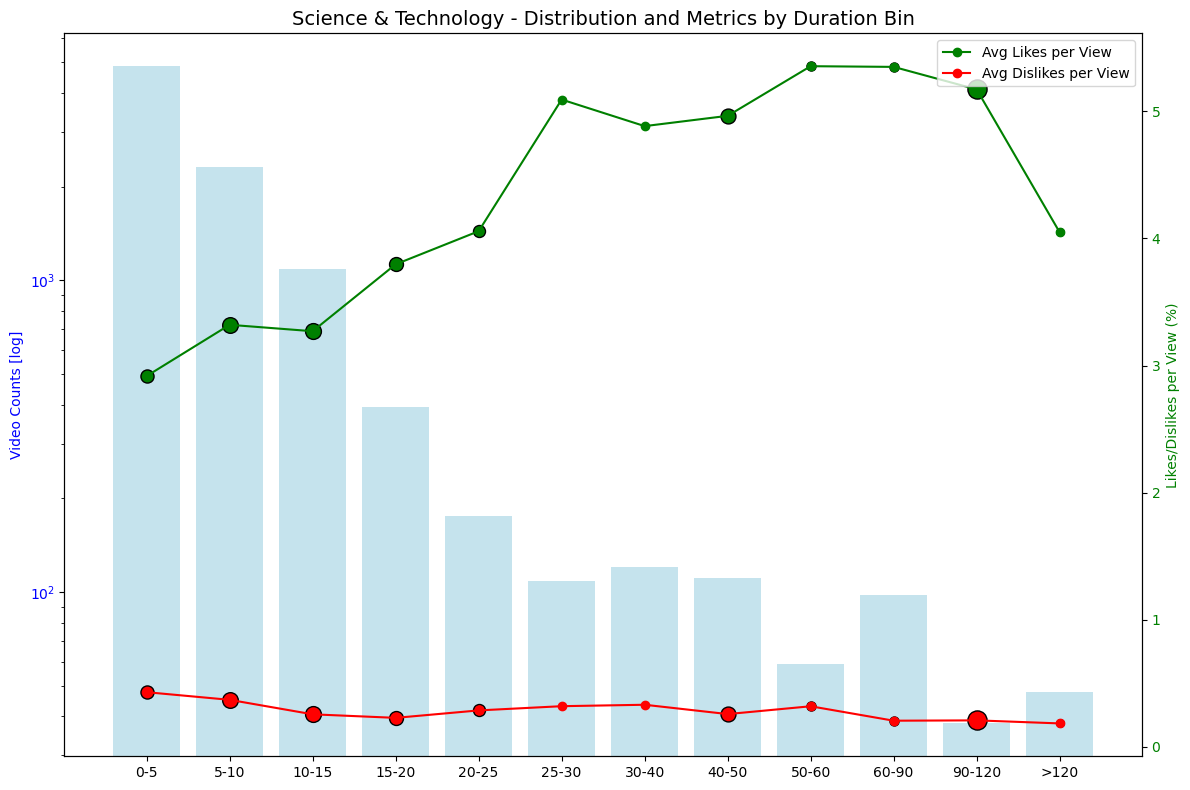

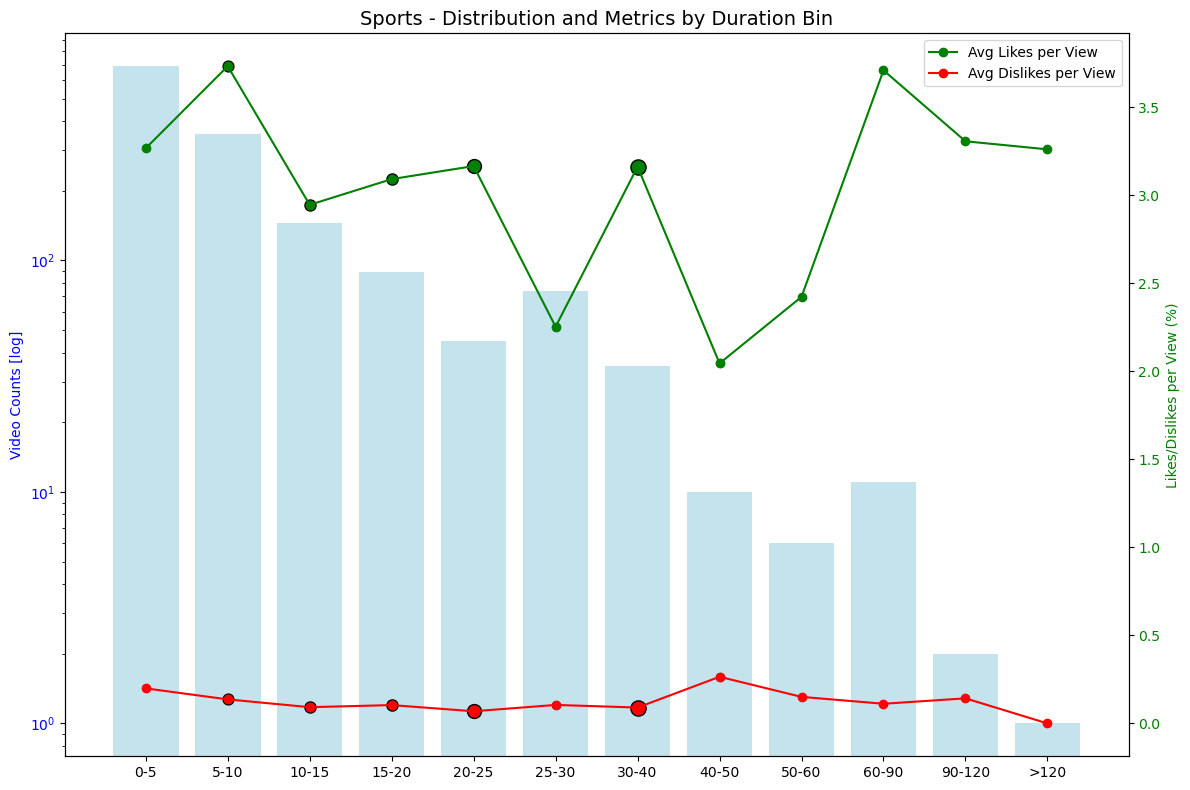

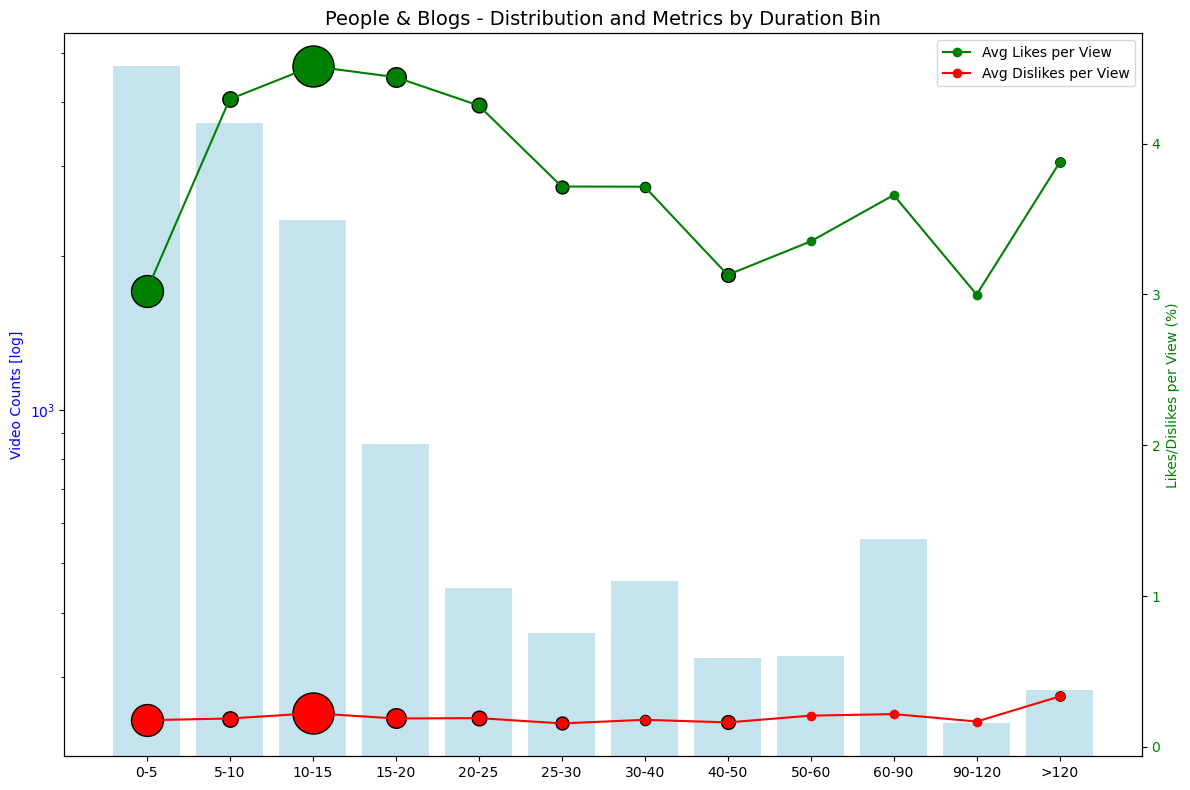

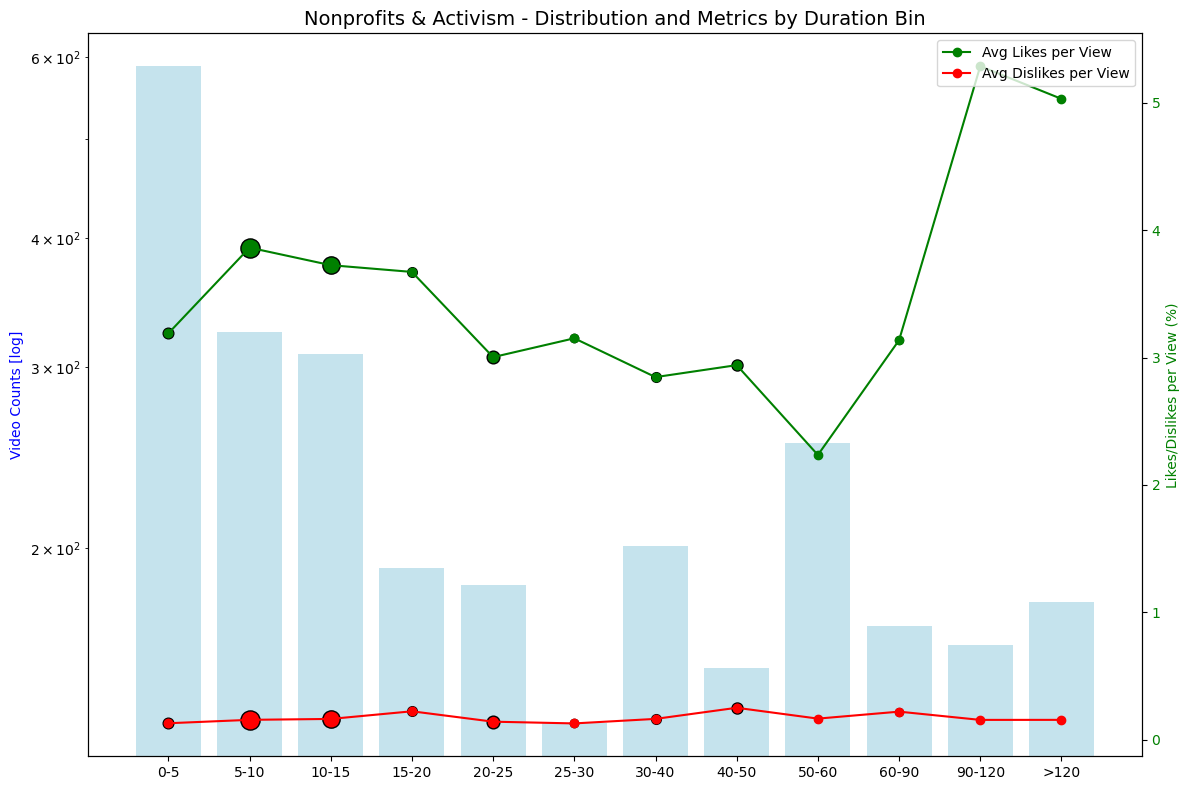

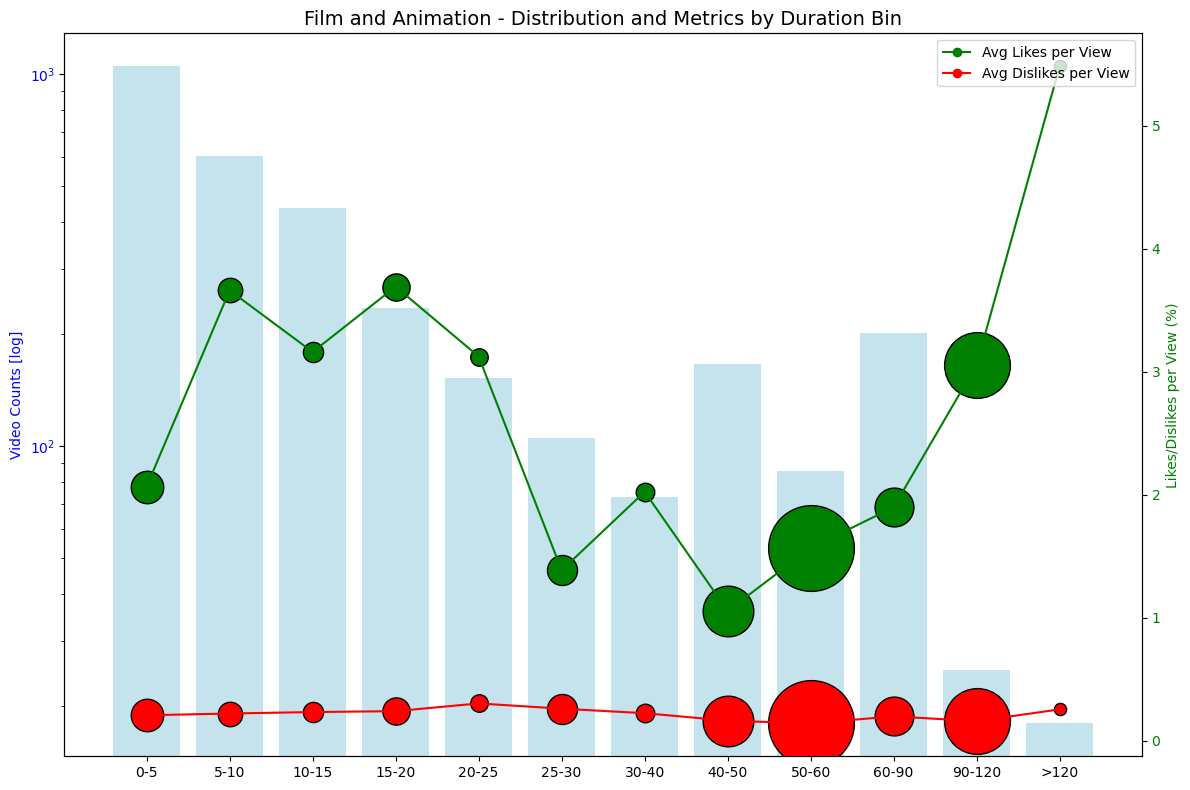

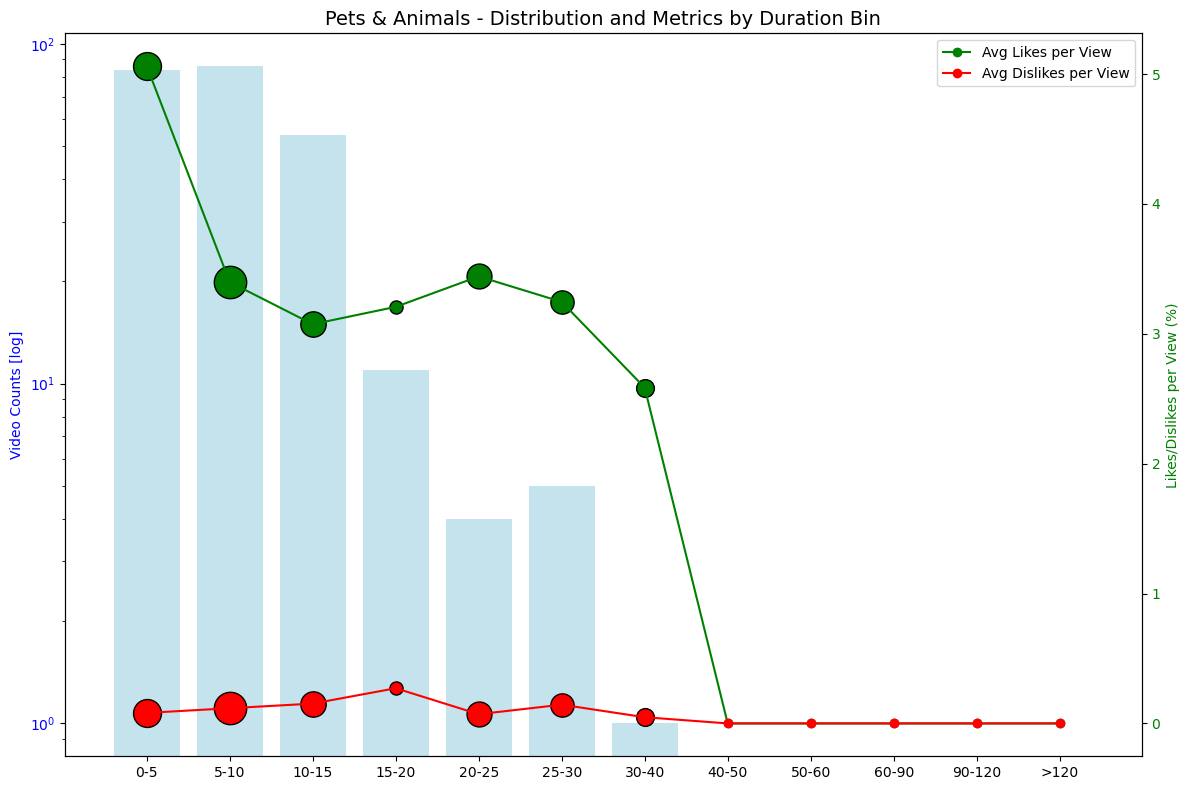

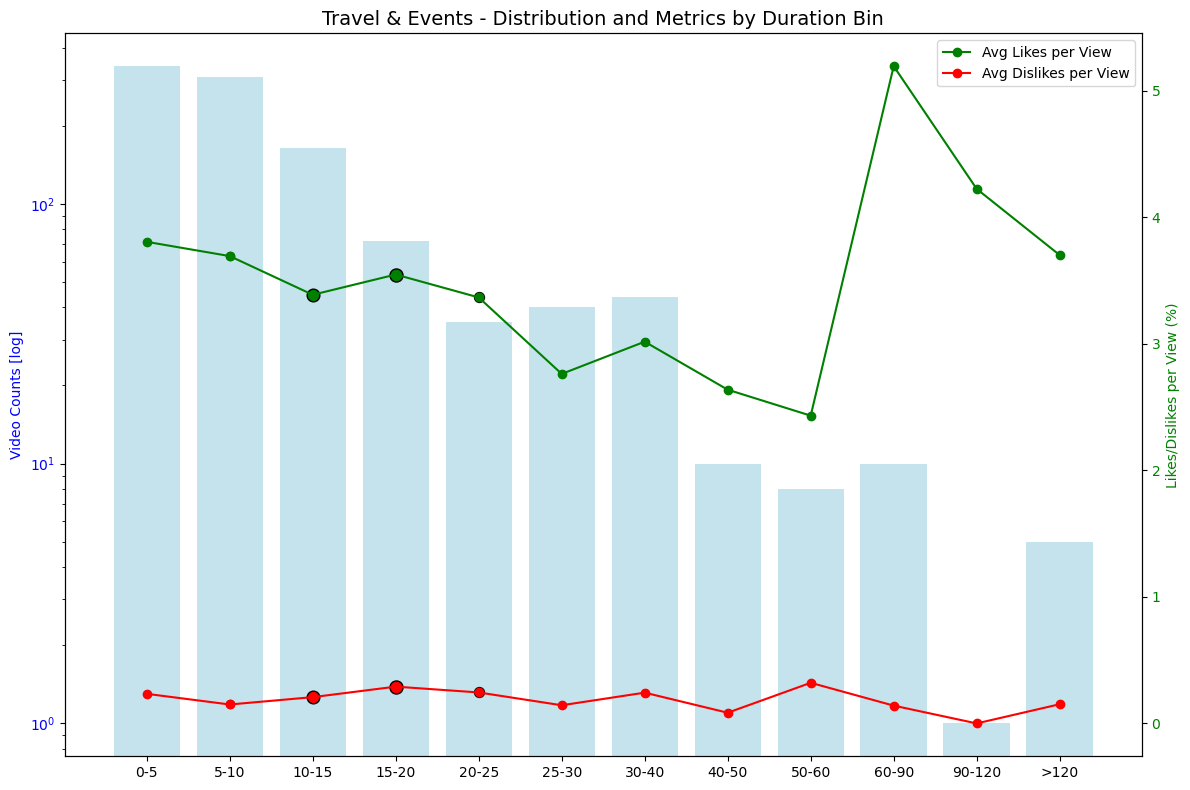

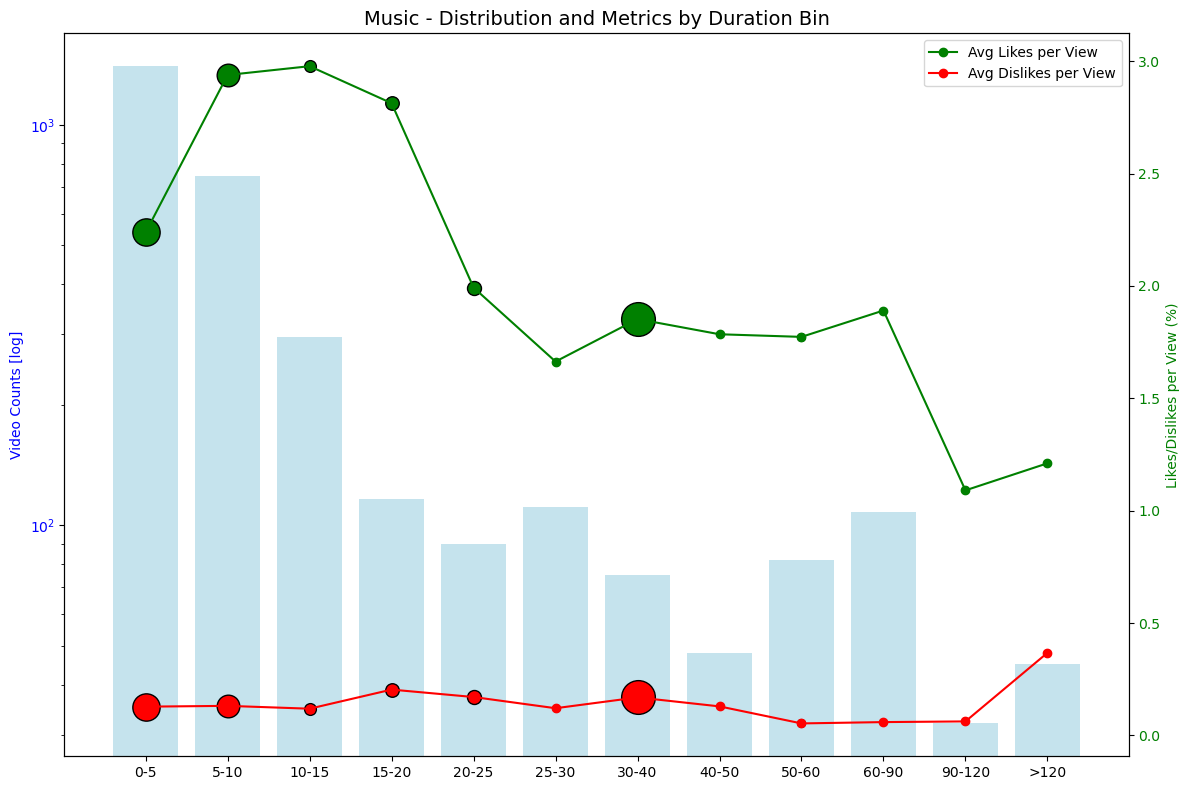

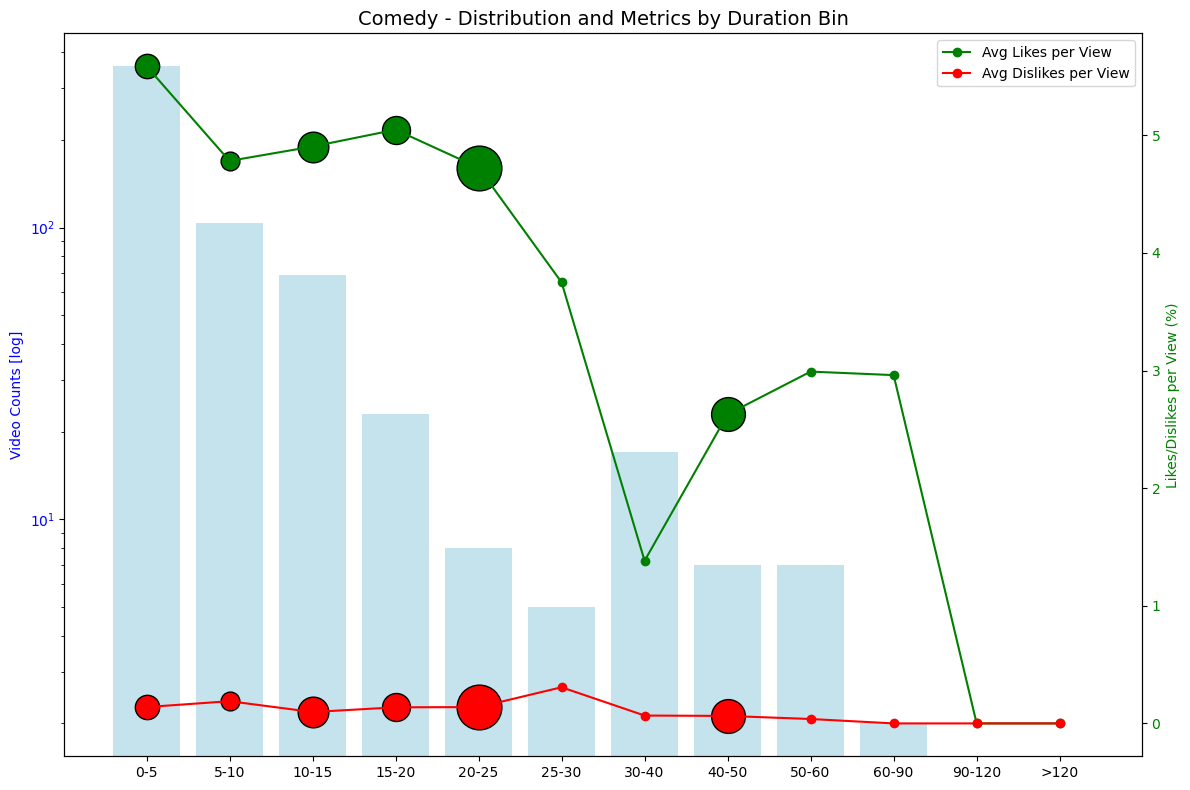

In [130]:
# Assume period_data is the DataFrame, and duration_bin_titles is defined
import math

categories = list(year_data['channel_category'].unique())
for category in categories:
    cat_data = year_data[year_data['channel_category'] == category]

    # Compute metrics
    bin_counts = cat_data.groupby('duration_bin')['duration_bin'].count()
    likes_per_view = cat_data.groupby('duration_bin')['likes_per_view'].mean()
    dislikes_per_view = cat_data.groupby('duration_bin')['dislikes_per_view'].mean()
    avg_views_per_video = cat_data.groupby('duration_bin')['view_count'].mean()

    likes_per_view = np.array([0 if math.isnan(x) else x for x in likes_per_view])
    dislikes_per_view = np.array([0 if math.isnan(x) else x for x in dislikes_per_view])
    avg_views_per_video = np.array([0 if math.isnan(x) else x for x in avg_views_per_video])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Bar plot for video counts
    ax.bar(bin_counts.index, bin_counts.values, color='lightblue', alpha=0.7, label='Video Counts')
    ax.set_ylabel('Video Counts [log]', color='blue')
    ax.set_yscale('log')
    ax.tick_params(axis='y', labelcolor='blue')

    # Create secondary y-axis for likes and dislikes per view
    ax2 = ax.twinx()
    ax2.plot(bin_counts.index, likes_per_view*100, color='green', marker='o', label='Avg Likes per View', linestyle='-')
    ax2.plot(bin_counts.index, dislikes_per_view*100, color='red', marker='o', label='Avg Dislikes per View', linestyle='-')

    ax2.set_ylabel('Likes/Dislikes per View (%)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add points with sizes based on average views per video
    for x, y_likes, y_dislikes, size in zip(bin_counts.index, likes_per_view, dislikes_per_view, avg_views_per_video):
        ax2.scatter(x, y_likes*100, s= (size/500), color='green', alpha=1, edgecolor='black')  # Scale size appropriately
        ax2.scatter(x, y_dislikes*100, s= (size/500), color='red', alpha=1, edgecolor='black')


    # Titles and legends
    ax.set_title(f'{category} - Distribution and Metrics by Duration Bin', fontsize=14)
    ax2.legend(loc='upper right')

    # General labels
    plt.xlabel('Duration Bin [min]')
    plt.tight_layout()
    path_to_fig = os.path.join(figures_path, 'Napoleon_plot', str(year))
    os.makedirs(path_to_fig, exist_ok=True)
                            
    plt.savefig(os.path.join(path_to_fig, category))


/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/2917944631.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = cat_data.groupby('duration_bin')['duration_bin'].count()
/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/2917944631.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  likes_per_view = cat_data.groupby('duration_bin')['like_count'].sum() / cat_data.groupby('duration_bin')['view_count'].sum()
/var/folders/db/w7pcw26x5mx6wkrqhdrk5c9c0000gn/T/ipykernel_87402/2917944631.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to 

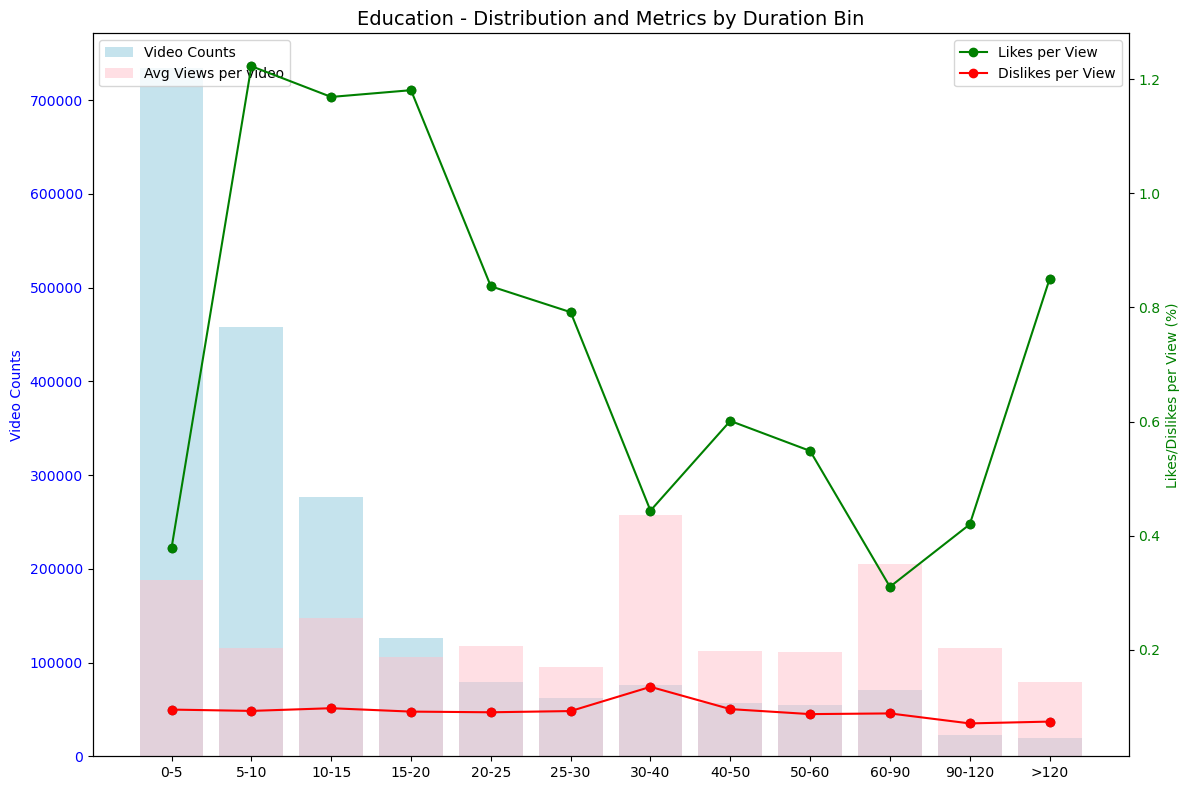

In [ ]:
# Assume period_data is the DataFrame, and duration_bin_titles is defined

categories = year_data['channel_category'].unique()
category = 'Education'
cat_data = year_data[year_data['channel_category'] == category]

# Compute metrics
bin_counts = cat_data.groupby('duration_bin')['duration_bin'].count()
likes_per_view = cat_data.groupby('duration_bin')['like_count'].sum() / cat_data.groupby('duration_bin')['view_count'].sum()
dislikes_per_view = cat_data.groupby('duration_bin')['dislike_count'].sum() / cat_data.groupby('duration_bin')['view_count'].sum()
avg_views_per_video = cat_data.groupby('duration_bin')['view_count'].sum() / cat_data.groupby('duration_bin')['duration_bin'].count()

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot for video counts
ax.bar(bin_counts.index, bin_counts.values, color='lightblue', alpha=0.7, label='Video Counts')
ax.bar(bin_counts.index, avg_views_per_video,  color='pink', alpha=0.5, label='Avg Views per video')
ax.set_ylabel('Video Counts', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for likes and dislikes per view
ax2 = ax.twinx()
ax2.plot(bin_counts.index, likes_per_view*100, color='green', marker='o', label='Likes per View', linestyle='-')
ax2.plot(bin_counts.index, dislikes_per_view*100, color='red', marker='o', label='Dislikes per View', linestyle='-')
ax2.set_ylabel('Likes/Dislikes per View (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add points with sizes based on average views per video
for x, y_likes, y_dislikes in zip(bin_counts.index, likes_per_view, dislikes_per_view,):
    ax2.scatter(x, y_likes*100, color='green', alpha=0.6, edgecolor='black')  # Scale size appropriately
    ax2.scatter(x, y_dislikes*100, color='red', alpha=0.6, edgecolor='black')

# Titles and legends
ax.set_title(f'{category} - Distribution and Metrics by Duration Bin', fontsize=14)
ax2.legend(loc='upper right')
ax.legend(loc='upper left')

# General labels
plt.xlabel('Duration Bin [min]')
plt.tight_layout()


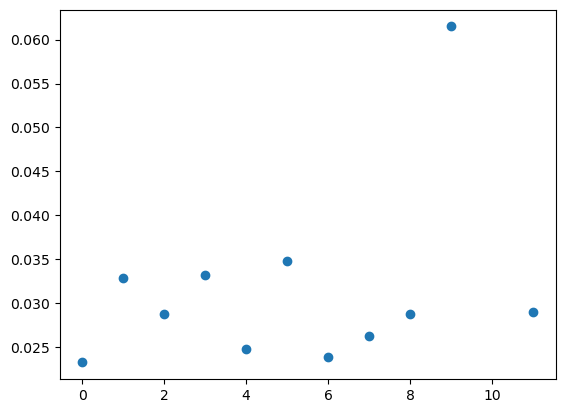

In [121]:
avg_views = np.array([188039.82491213072,
             115131.73004184247,
            147180.00374478986,
            105399.32377586275,
            117921.55934768626,
            95112.79035451933,
            257204.76840248285,
            111939.9032525634,
            110861.18397888949,
            204956.64037228306,
            115575.08854709766,
            78983.49428484726])

# plt.axhline(y = 500, color = 'r', linestyle = '-') 
# plt.axhline(y = 100, color = 'r', linestyle = '-') 
# plt.scatter(np.arange(len(avg_views)), (avg_views/250) , s = 100)
plt.scatter(np.arange(len(likes_per_view)), likes_per_view)